#ИМПОРТ БИБЛИОТЕК

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')

#Подключаем colab к kaggle

In [143]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Kaggle'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Загружаем датасет

In [144]:
# !pwd
# %cd gdrive/MyDrive/Kaggle
# !kaggle datasets download -d robikscube/hourly-energy-consumption
# !unzip hourly-energy-consumption.zip -d hourly-energy-consumption
# %cd hourly-energy-consumption
# !ls

#Указываем путь и подгружаем датасет


In [145]:
%cd gdrive/MyDrive/Kaggle/hourly-energy-consumption
!ls

[Errno 2] No such file or directory: 'gdrive/MyDrive/Kaggle/hourly-energy-consumption'
/content/gdrive/MyDrive/Kaggle/hourly-energy-consumption
AEP_hourly.csv	   DEOK_hourly.csv  EKPC_hourly.csv	NI_hourly.csv	    PJM_Load_hourly.csv
COMED_hourly.csv   DOM_hourly.csv   est_hourly.paruqet	PJME_hourly.csv     PJMW_hourly.csv
DAYTON_hourly.csv  DUQ_hourly.csv   FE_hourly.csv	pjm_hourly_est.csv


In [146]:
config = {
    'BASE_SCORE' : 0.5,
    'N_FOLDS' : 5,
    'RANDOM_STATE': 123,
    'N_ESTIMATORS' : 5000,
    'LEARNING_RATE': 0.005,
    'BOOSTER': 'gbtree',
    'EARLY_STOPPING_ROUNDS' : 50,
    'OBJECTIVE' : 'reg:linear',
    'MAX_DEPTH' : 10,
    'VERBOSE' : 100
}

# Подготовка и анализ

In [147]:
df=pd.read_csv('AEP_hourly.csv')
df=df.sort_values(by=['Datetime'])
df=df.set_index('Datetime')

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [149]:
df.index=pd.to_datetime(df.index)



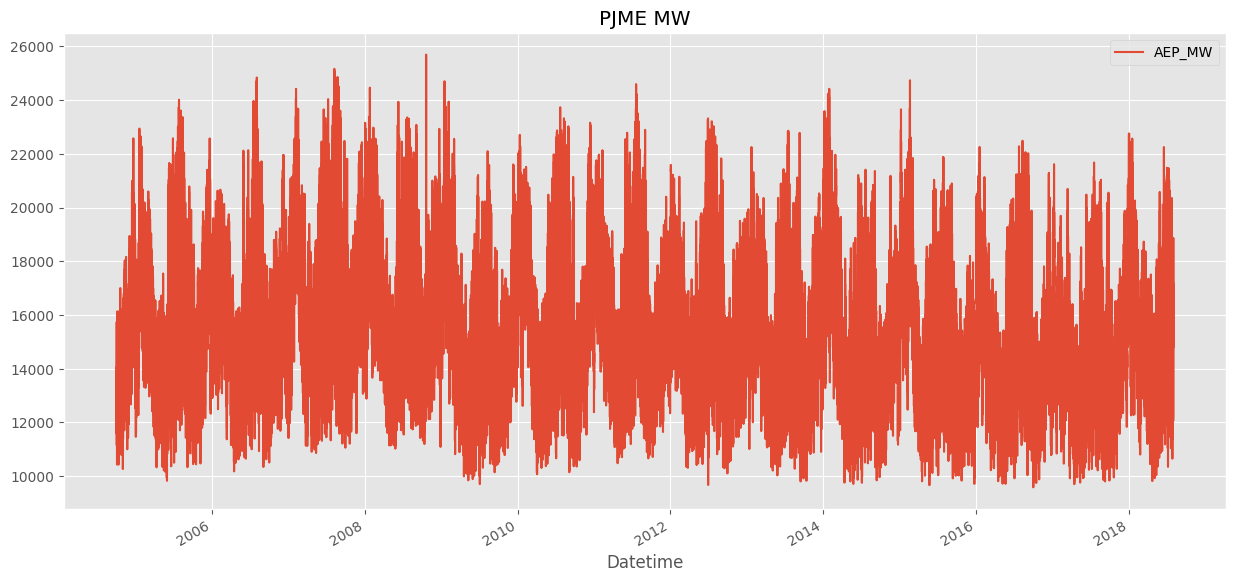

In [150]:
df.plot(style='-', figsize=(15,7), title = 'PJME MW')
plt.show()

# Делим df на Train Test

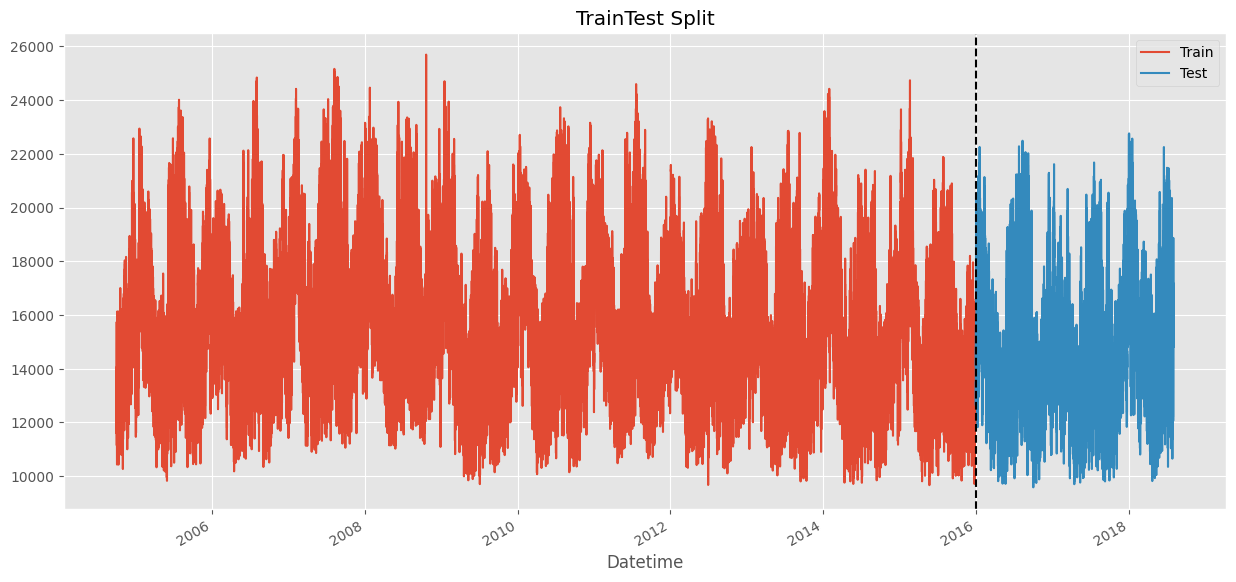

In [151]:
train = df.query('Datetime<2016')
test  = df.query('Datetime>=2016')

fig, ax = plt.subplots(figsize=(15, 7))
train['AEP_MW'].plot(ax=ax, title='TrainTest Split')
test['AEP_MW'].plot(ax=ax, label='Test Set')
ax.axvline('2016', color='black', ls='--')
ax.legend(['Train', 'Test'])
plt.show()

# Смотрим недельную \ дневню сезонность

<Axes: title={'center': 'Week'}, xlabel='Datetime'>

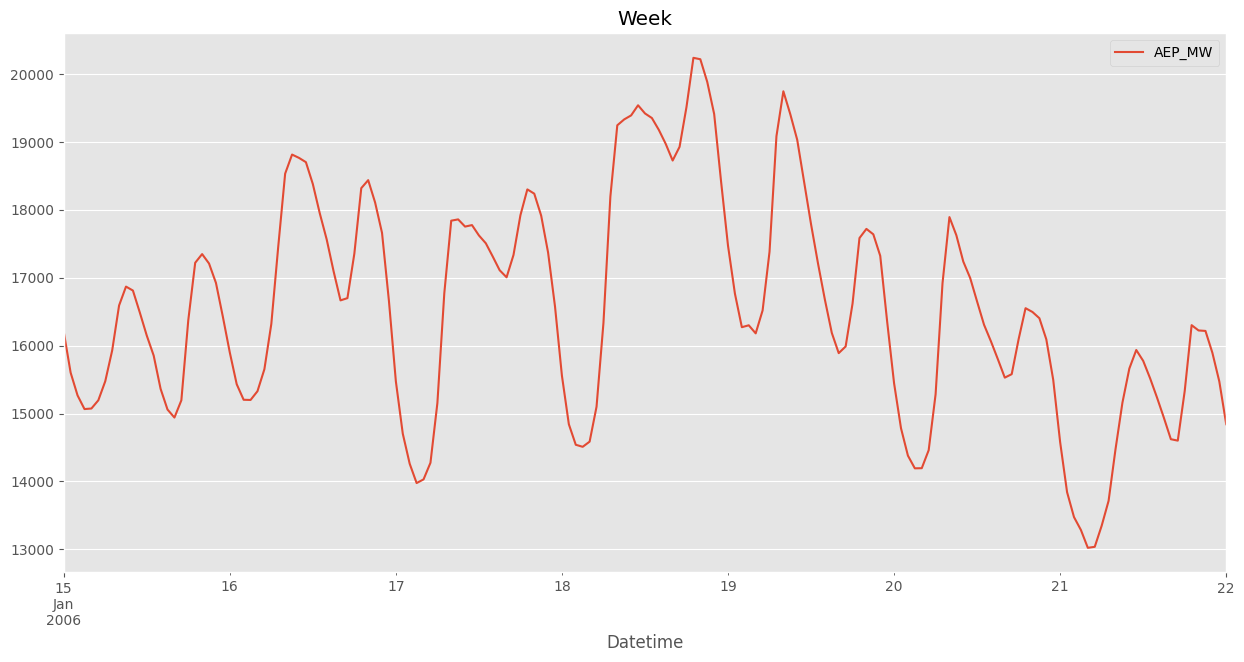

In [152]:
df[11300:11469].plot(figsize=(15,7), title = "Week")

# Делаем Feature importance относительно увиденного.

In [153]:
def features(df):
  df = df.copy()
  df['hour']=df.index.hour
  df['dayofyear']=df.index.dayofyear
  df['dayofweek']=df.index.dayofweek
  df['month']=df.index.month
  df['year']=df.index.dayofyear

  return df




In [154]:
df=features(df)

In [155]:
df

,AEP_MW,hour,dayofyear,dayofweek,month,year
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,1,275,4,10,275
2004-10-01 02:00:00,11935.0,2,275,4,10,275
2004-10-01 03:00:00,11692.0,3,275,4,10,275
2004-10-01 04:00:00,11597.0,4,275,4,10,275
2004-10-01 05:00:00,11681.0,5,275,4,10,275
...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,214,3,8,214
2018-08-02 21:00:00,17303.0,21,214,3,8,214
2018-08-02 22:00:00,17001.0,22,214,3,8,214


#Суточные изменения

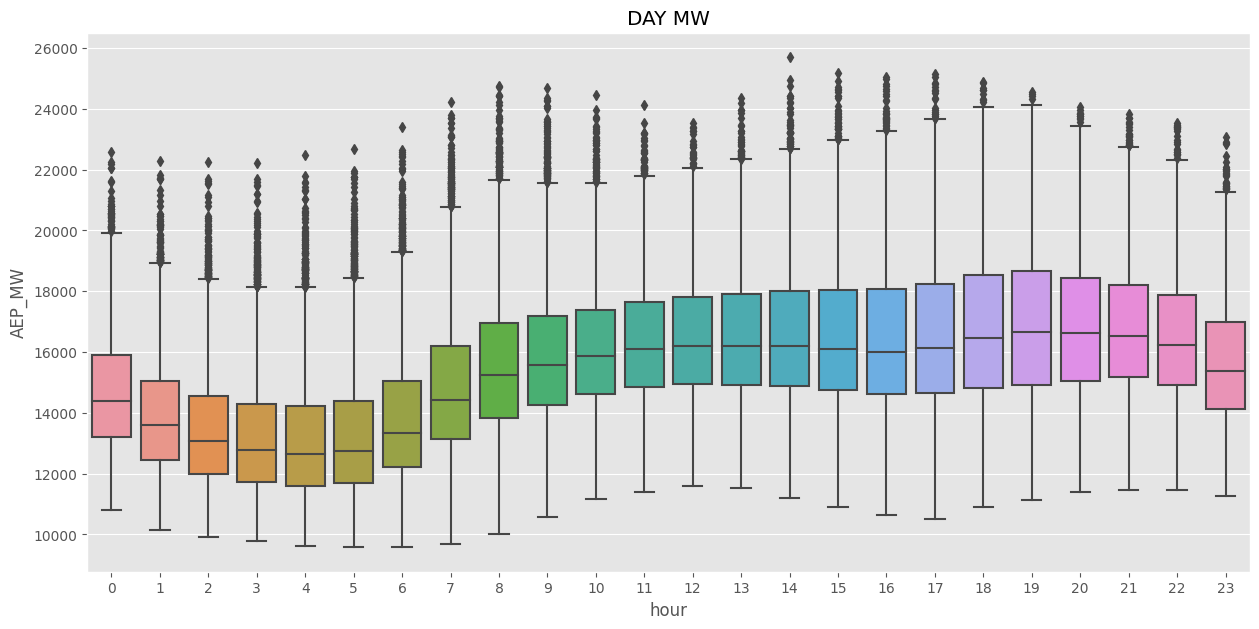

In [156]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=df, x ='hour', y = 'AEP_MW')
ax.set_title("DAY MW")
plt.show()

#Годовые изменения


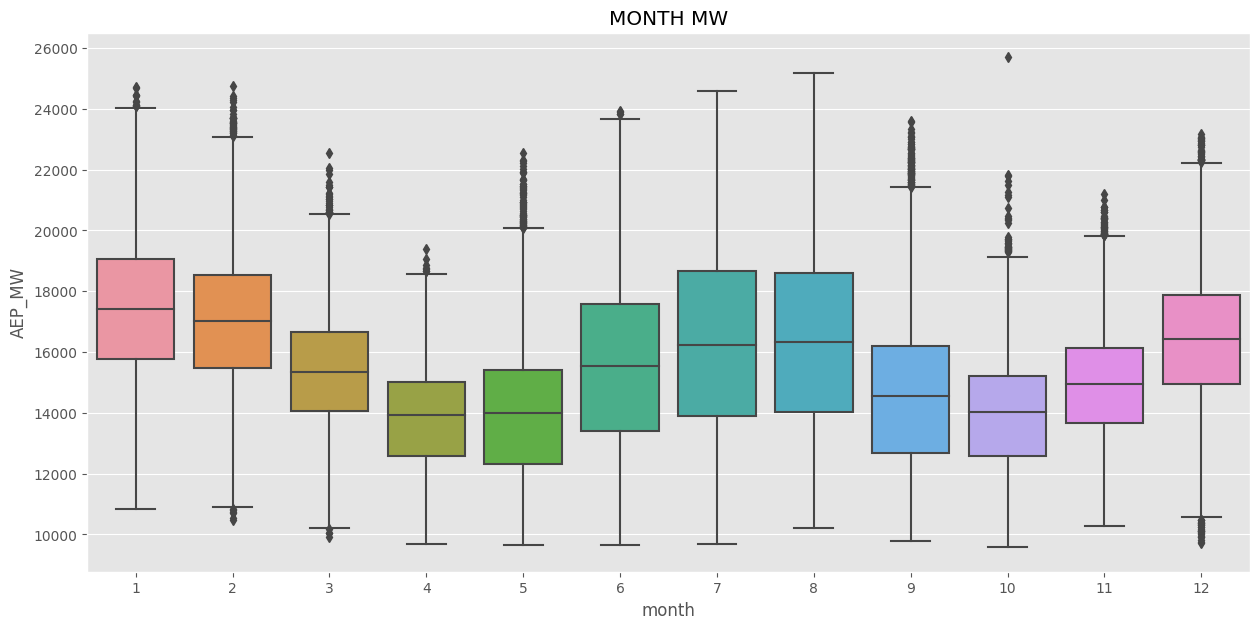

In [157]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=df, x ='month', y = 'AEP_MW')
ax.set_title("MONTH MW")
plt.show()

In [158]:
df.columns

Index(['AEP_MW', 'hour', 'dayofyear', 'dayofweek', 'month', 'year'], dtype='object')

# Создаем группы и добавляем их в дф для перекрестной проверки.

In [159]:
train_kf = df.index

kf = KFold(n_splits=config['N_FOLDS'],
           shuffle=True,
           random_state=config['RANDOM_STATE'])

# Создаем группы и добавляем в трейн
fold = 1
for tr_idx, val_idx in kf.split(train_kf):
    fold_vids = train_kf[val_idx]
    df.loc[df.index.isin(fold_vids), 'fold'] = fold
    fold += 1
df['fold'] =df['fold'].astype('int')

In [160]:
df.value_counts('fold')

fold
2    24256
4    24255
5    24255
3    24254
1    24253
dtype: int64

In [161]:
train = df.query('Datetime<2016')
test  = df.query('Datetime>=2016')

In [162]:
FEATURES = ['hour', 'dayofyear', 'dayofweek', 'month', 'year']
TARGET = 'AEP_MW'



In [163]:

fold_df= test[['AEP_MW', 'fold']]

# Строим модель и делаем прогнозы  перекрестной проверкой c преждевременной остановлением от переобучения.


In [164]:
models = [] # создаем список моделей
fil = []

for fold in range(1, 6):
    print(f'Fold {fold} running')
    # разбиваем трейн относительно текущей группы
    X_tr = train.query('fold != @fold')[FEATURES]
    X_te = test.query('fold == @fold')[FEATURES]

    y_tr = train.query('fold != @fold')[TARGET]
    y_te = test.query('fold == @fold')[TARGET]

    # Создаем модель
    reg=xgb.XGBRegressor(base_score=config['BASE_SCORE'],
                         booster=config['BOOSTER'],
                         early_stopping_rounds=config['EARLY_STOPPING_ROUNDS'],
                         n_estimators=config['N_ESTIMATORS'],
                         objective=config['OBJECTIVE'],
                         max_depth=config['MAX_DEPTH'],
                         learning_rate=config['LEARNING_RATE'])

    # Обучаем модель с остановкой от переобучения
    reg.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_te, y_te)],
            verbose=config['VERBOSE'])

    # прогноз относительно текущей группы
    fold_preds = reg.predict(X_te)
    fold_df.loc[fold_df['fold'] == fold, 'preds'] = fold_preds
    fold_score = mean_absolute_error(
        fold_df.query('fold == @fold')['AEP_MW'],
            fold_df.query('fold == @fold')['preds']
    )
    fi=pd.DataFrame(columns=[f'{fold}_importance'],
             data=reg.feature_importances_,
             index=reg.feature_names_in_,
             )
    print(f'Score of this fold is {fold_score:0.2f}')
    models.append(reg)
    fil.append(fi)

Fold 1 running
[0]	validation_0-rmse:15795.91035	validation_1-rmse:14919.12952


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:35:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9642.92838	validation_1-rmse:8761.12522
[200]	validation_0-rmse:5950.09084	validation_1-rmse:5090.60513
[300]	validation_0-rmse:3764.56407	validation_1-rmse:2980.93910
[400]	validation_0-rmse:2510.67180	validation_1-rmse:1905.15139
[500]	validation_0-rmse:1834.37197	validation_1-rmse:1516.12846
[600]	validation_0-rmse:1499.78962	validation_1-rmse:1476.64294
[619]	validation_0-rmse:1460.61162	validation_1-rmse:1485.11583
Score of this fold is 1117.26
Fold 2 running
[0]	validation_0-rmse:15792.02230	validation_1-rmse:14918.23371


<ipython-input-164-4c9de7d69060>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_df.loc[fold_df['fold'] == fold, 'preds'] = fold_preds
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:35:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9640.99784	validation_1-rmse:8755.10545
[200]	validation_0-rmse:5949.57127	validation_1-rmse:5078.97133
[300]	validation_0-rmse:3765.00732	validation_1-rmse:2969.28985
[400]	validation_0-rmse:2512.90997	validation_1-rmse:1904.76294
[500]	validation_0-rmse:1838.05294	validation_1-rmse:1534.03613
[600]	validation_0-rmse:1504.45350	validation_1-rmse:1510.57415
[606]	validation_0-rmse:1491.38009	validation_1-rmse:1513.62718
Score of this fold is 1137.26
Fold 3 running
[0]	validation_0-rmse:15803.66837	validation_1-rmse:14881.18005


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:36:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9648.15531	validation_1-rmse:8718.38495
[200]	validation_0-rmse:5954.10531	validation_1-rmse:5046.27520
[300]	validation_0-rmse:3767.90964	validation_1-rmse:2940.68526
[400]	validation_0-rmse:2514.42126	validation_1-rmse:1882.80834
[500]	validation_0-rmse:1837.93578	validation_1-rmse:1525.34886
[600]	validation_0-rmse:1503.50918	validation_1-rmse:1512.96873
Score of this fold is 1130.60
Fold 4 running
[0]	validation_0-rmse:15798.90077	validation_1-rmse:14917.88356


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:36:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9645.49548	validation_1-rmse:8743.88091
[200]	validation_0-rmse:5952.58306	validation_1-rmse:5066.66132
[300]	validation_0-rmse:3767.31568	validation_1-rmse:2958.70388
[400]	validation_0-rmse:2513.65940	validation_1-rmse:1899.08180
[500]	validation_0-rmse:1836.85425	validation_1-rmse:1538.22048
[600]	validation_0-rmse:1501.78589	validation_1-rmse:1520.69474
[604]	validation_0-rmse:1493.05565	validation_1-rmse:1522.83381
Score of this fold is 1132.25
Fold 5 running
[0]	validation_0-rmse:15798.36806	validation_1-rmse:14912.10836


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:36:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9644.79787	validation_1-rmse:8751.49961
[200]	validation_0-rmse:5951.92844	validation_1-rmse:5076.84285
[300]	validation_0-rmse:3766.38774	validation_1-rmse:2970.49457
[400]	validation_0-rmse:2513.48611	validation_1-rmse:1905.44156
[500]	validation_0-rmse:1837.94904	validation_1-rmse:1534.09548
[600]	validation_0-rmse:1503.26001	validation_1-rmse:1508.60440
[610]	validation_0-rmse:1481.78159	validation_1-rmse:1514.02964
Score of this fold is 1134.32


# Смотрим значимость факторов

In [165]:
fil_df = pd.concat(fil, axis=1)

<Axes: title={'center': 'Feature Importance'}>

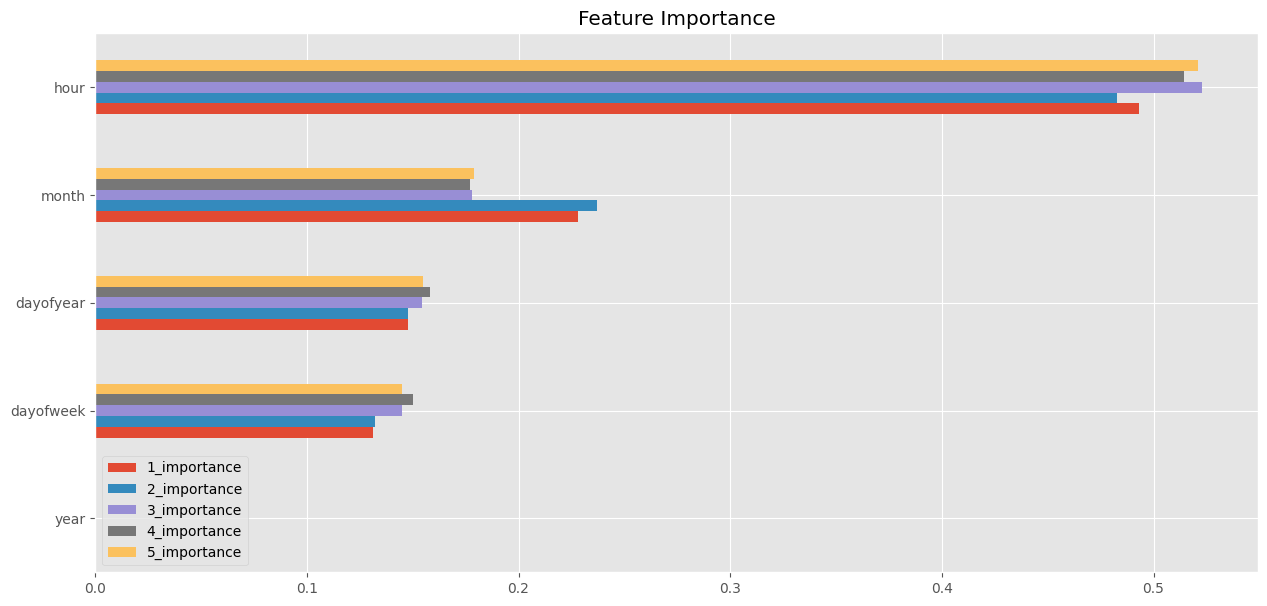

In [166]:
fil_df.sort_values('4_importance').plot(kind='barh', figsize=(15, 7), title='Feature Importance')

In [167]:
fold_df

,AEP_MW,fold,preds
Datetime,,,
2016-01-01 00:00:00,13487.0,3,14346.887695
2016-01-01 01:00:00,13135.0,4,13994.371094
2016-01-01 02:00:00,12912.0,2,13869.167969
2016-01-01 03:00:00,12685.0,2,13858.303711
2016-01-01 04:00:00,12631.0,3,13995.929688
...,...,...,...
2018-08-02 20:00:00,17673.0,2,18777.025391
2018-08-02 21:00:00,17303.0,3,18819.712891
2018-08-02 22:00:00,17001.0,4,18939.650391


# Сравнение прогноза с реальными данными

In [168]:
df = df.merge(fold_df['preds'], how='left', left_index=True, right_index=True)

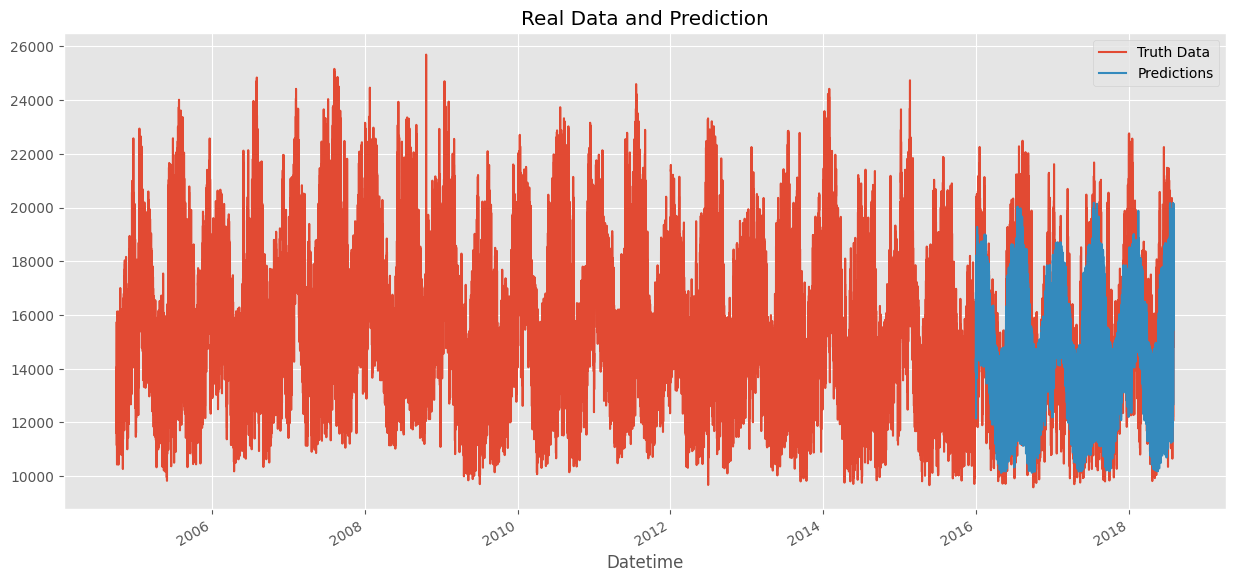

In [169]:
ax = df[['AEP_MW']].plot(figsize=(15, 7))
df['preds'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Real Data and Prediction')
plt.show()

# Недельные изменения

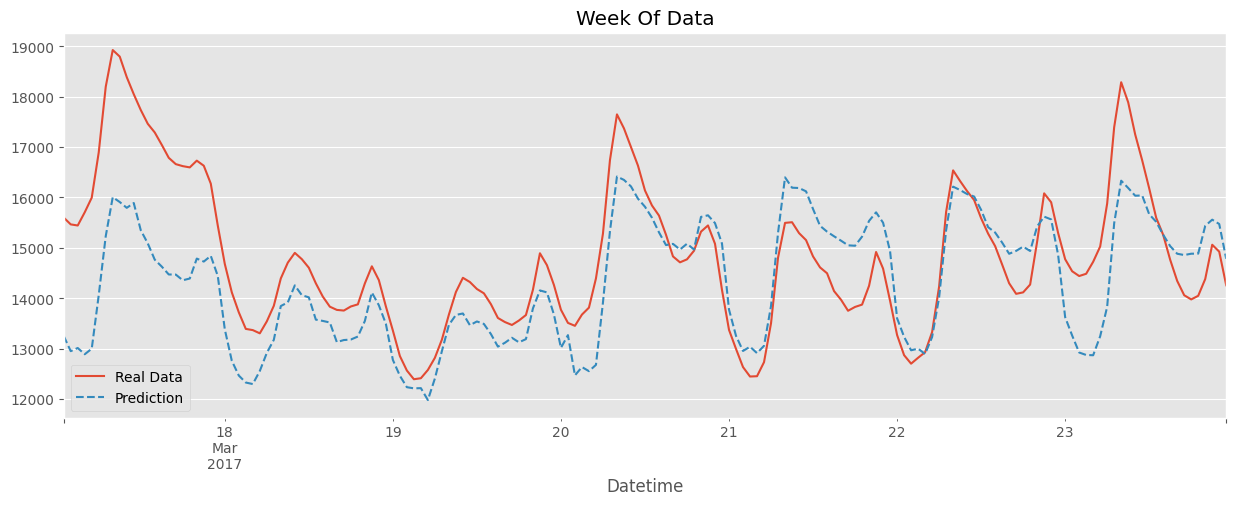

In [175]:
ax = df.loc[(df.index > '03-17-2017') & (df.index < '03-24-2017')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '03-17-2017') & (df.index < '03-24-2017')]['preds'] \
    .plot(style='--')
plt.legend(['Real Data','Prediction'])
plt.show()

In [171]:
s1=mean_absolute_error(test['AEP_MW'], fold_df['preds'])
s2=np.sqrt(mean_squared_error(test['AEP_MW'], fold_df['preds']))
print(f'MAE Score on Test set: {s1:0.2f}')
print(f'MSE Score on Test set: {s2:0.2f}')

MAE Score on Test set: 1130.36
MSE Score on Test set: 1494.17


In [172]:
fold_df['date']=fold_df.index.date
fold_df['MAE']=np.abs(fold_df['AEP_MW']-fold_df['preds'])

<ipython-input-172-714cc509e43b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_df['date']=fold_df.index.date
<ipython-input-172-714cc509e43b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_df['MAE']=np.abs(fold_df['AEP_MW']-fold_df['preds'])


# ТОП 10 дней с худщими предсказаниями

In [173]:
fold_df.groupby(['date']).mean().sort_values('MAE', ascending=False).head(10)

,AEP_MW,fold,preds,MAE
date,,,,
2018-01-06,20847.833333,3.083333,14646.972656,6200.861165
2018-01-02,20938.500000,3.000000,15325.585938,5612.914144
2018-01-07,19803.375000,2.666667,14565.132812,5238.241984
2018-01-01,19513.500000,3.083333,14652.952148,4860.548625
2017-12-31,18381.750000,3.083333,13964.520508,4417.229248
2018-01-05,21166.833333,3.041667,16797.568359,4369.263957
2017-01-08,18945.208333,3.208333,14589.504883,4355.703491
2018-01-14,18390.083333,3.125000,14349.747070,4040.335653
2017-12-28,19396.291667,3.250000,15392.816406,4003.475057


# ТОП 10 дней с лучшими предсказаниями

In [174]:
fold_df.groupby(['date']).mean().sort_values('MAE').head(10)

,AEP_MW,fold,preds,MAE
date,,,,
2016-06-05,13068.500000,3.000000,12942.637695,162.820190
2017-12-07,16638.250000,2.916667,16564.138672,164.506551
2017-05-21,12105.500000,3.041667,11991.153320,169.111450
2017-04-01,12569.208333,3.083333,12721.593750,176.511068
2017-10-12,13403.750000,2.666667,13560.031250,177.454508
2016-06-17,15176.750000,2.916667,15273.838867,200.885295
2017-01-28,15610.250000,3.333333,15643.796875,202.111491
2016-02-26,16656.000000,2.833333,16511.248047,202.579468
2016-12-13,16492.708333,3.375000,16370.247070,206.255900
